<a href="https://colab.research.google.com/github/Martinmbiro/Card-classification/blob/main/02%20Cards%20end%20to%20end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cards End to end**
> In this notebook, I'll be using the modules I wrote in the preceding notebook `01 Cards modular.ipynb` to finally train a model that classifies playing card images from the `kaggle`dataset linked [`here`](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification)

> At the end of the notebook, I'll also include logic to upload a custom card image and run inference on it.

In [ ]:
# to delete /content/helper_modules/ directory
# !rm -rf /content/helper_modules/

In [ ]:
import torch, torchvision, matplotlib.pyplot as plt, numpy as np, seaborn as sns
import requests, zipfile
from pathlib import Path

# for future reference, print versions
print(f'torch version: {torch.__version__}')
print(f'torchvison version: {torchvision.__version__}')

torch version: 2.6.0+cu124
torchvison version: 0.21.0+cu124


In [ ]:
# set up device
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

# print current device & GPU type
print(f'device: {device}')
print(f'GPU: {torch.cuda.get_device_name()}')

device: cuda
GPU: Tesla T4


### Get helper modules
> The function below makes use of the [`requests`](https://requests.readthedocs.io/) and [`zipfile`](https://docs.python.org/3/library/zipfile.html) modules to download and extract zipfile containing the custom helper modules from my GitHub repository linked [here](https://github.com/Martinmbiro/Card-classification/raw/refs/heads/main/helper%20modules/modules.zip)

> 📝 **Note**
+ The link passed to `requests.get()` should be the _raw_ link to the file on GitHub, otherwise it won't work.

In [ ]:
%%time
# raw link to the zip folder
link = 'https://github.com/Martinmbiro/Card-classification/raw/refs/heads/main/helper%20modules/modules.zip'

# make a get request to the link
r = requests.get(url=link, stream=True)

# check if response was successful
if r.status_code != 200:
  print(f'Unsuccessful Response! ERROR CODE: {r.status_code}\n.\nRe-run this cell to try again')
else:
  # create download folder
  HELPER_MODULES = Path('helper_modules')
  HELPER_MODULES.mkdir(parents=True, exist_ok=True)

  # specify zipfile directory
  ZIP_FILE = HELPER_MODULES.joinpath('modules.zip')

  # download online file and write to 'downloads/modules.zip'
  with ZIP_FILE.open(mode='wb') as f:
    for chunk in r.iter_content(chunk_size=200):
      f.write(chunk)

  # if valid zipfile, then extract
  if zipfile.is_zipfile(ZIP_FILE):
    # extract
    with zipfile.ZipFile(file=ZIP_FILE, mode='r') as zp:
      zp.extractall(path=HELPER_MODULES)
      print(f'{ZIP_FILE.name} EXTRACTED TO: {Path.cwd().joinpath(HELPER_MODULES)}\n')
  else:
    print('A valid zip file was not downloaded.\nPlease check the link and retry!')

modules.zip EXTRACTED TO: /content/helper_modules

CPU times: user 23.1 ms, sys: 979 µs, total: 24 ms
Wall time: 917 ms


In [ ]:
# import helper modules
from helper_modules import data_loader, model_builder, train_test, utils

### Load the data
> Here, I'll load the following from the `data_loader.py` module:
+ `train_dl` - A `Dataloader` for training `Dataset`
+ `test_dl` - A `Dataloader` for test `Dataset`
+ `y_true` - A `numpy.ndarray` of true class labels from test `Dataset`
+ `label_map` - A `dict` mapping class indices to class names

In [ ]:
%%time
# get dataloaders for train, test, validation & a label_map
train_dl, test_dl, val_dl, label_map = data_loader.get_dataloaders()

CPU times: user 22.4 s, sys: 2.16 s, total: 24.6 s
Wall time: 1min 32s


In [ ]:
# length of train, test, validation dataloaders (no. batches)
len(train_dl), len(test_dl), len(val_dl)

(239, 9, 9)

In [ ]:
# length of training and test datasets samples
len(train_dl.dataset), len(test_dl.dataset), len(val_dl.dataset)

(7624, 265, 265)

#### Visualizing a random training batch
> Here, I'll take a random batch from the training `DataLoader` and visualize it

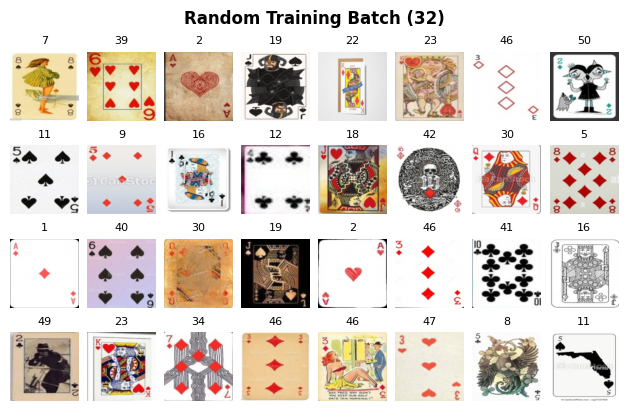

In [ ]:
# get random batch
x_batch, y_batch = next(iter(train_dl))

# figure and sub
f, axs = plt.subplots(4, 8, figsize=(8.0, 4.0), layout='compressed')
# plot
for x, ax in enumerate(axs.flat):
  ax.set_title(y_batch[x].item(), fontsize=8)
  ax.axis(False)
  ax.imshow(x_batch[x].permute(1,2,0))

# suptitle
f.suptitle('Random Training Batch (32)', weight='black')
plt.show()

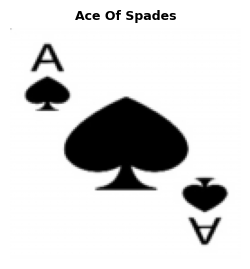

In [ ]:
# visualize a random image from the training dataset
img, lb = train_dl.dataset[np.random.randint(len(train_dl.dataset))]

plt.figure(figsize=(3,3))
plt.axis(False)
plt.title(train_dl.dataset.idx_to_class[lb].title(), fontsize=9, weight='black')
plt.imshow(img.permute(1,2,0))
plt.show()

#### Visualizing training data distribution
> Here, I'll visualize the distribution of the training dataset in the `/content/cards/train` directory in our file explorer
+ To do this, we'll make use of a few tricks from Pathlib: [`Path.diriter()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.iterdir), [`Path.name`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.name), the python [`dictionary`](https://realpython.com/python-dicts/#adding-key-value-pairs-and-updating-dictionaries) and the [`seaborn`]() libary for visualization

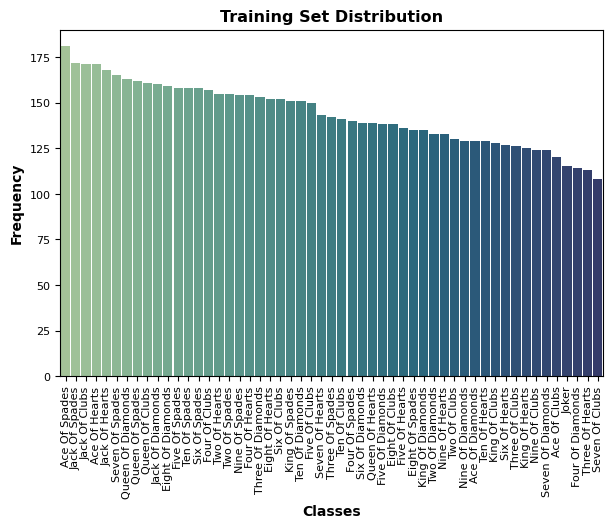

In [ ]:
# turn 'train' path into a PosixPath object
train = Path('/content/cards/train')

# empty dict
data_dist = dict()

# loop through each directory in 'train' directory
for d in train.iterdir():
  # add card class name & frequency to the dictionary
  data_dist[d.name.title()] = [len(list(d.iterdir()))]

# sort the dictionary by values
data_dist = dict(sorted(data_dist.items(), key=lambda item:item[1], reverse=True))

# set up axes and properties
f, ax = plt.subplots(figsize=(7, 4.5))
ax.xaxis.set_tick_params(rotation=90, labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
ax.set_ylabel('Frequency', weight='black')
ax.set_xlabel('Classes', weight='black')
ax.set_title('Training Set Distribution', fontsize=11.5, weight='black')

# plot
sns.barplot(data=data_dist, gap=0.1, width=1.0, ax=ax, palette='crest')

plt.show()

> 🔔 **Note**
+ Our training data is unevenly distributed across the 53 classes
+ While there's lots of ways we could go about this, for the sake of this project, I'll just make sure not to lean towards the `accurary` metric when training, but rather, `f1_score`

### Get model, optimizer, loss function
> Here, we'll define a model, optimize and loss function with the help of the `model_builder.py` module

In [ ]:
%%time
# get model, optimizer, and loss function
model, opt, loss_fn = model_builder.get_model(device)

model.safetensors:   0%|          | 0.00/40.4M [00:00<?, ?B/s]

CPU times: user 573 ms, sys: 173 ms, total: 747 ms
Wall time: 10.1 s


#### Visualize structure of neural network
> We'll do this using the [`torchinfo`](https://github.com/TylerYep/torchinfo) library

In [ ]:
# install torchinfo
!pip install torchinfo
from torchinfo import summary

In [ ]:
# visualize model structure
summary(model, input_size=(1, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 53]                   --
├─Sequential: 1-1                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 24, 64, 64]           648
│    └─BatchNorm2d: 2-2                  [1, 24, 64, 64]           48
│    └─ReLU: 2-3                         [1, 24, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 32, 64, 64]           6,912
│    └─BatchNorm2d: 2-5                  [1, 32, 64, 64]           64
│    └─ReLU: 2-6                         [1, 32, 64, 64]           --
│    └─Conv2d: 2-7                       [1, 64, 64, 64]           18,432
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 256, 32, 32]          --
│    └

### Early stopping
> 💎 **Pro Tip**

> [Early stopping](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.) is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, I'll define an object of `EarlyStopping` class from `utils.py`

In [ ]:
# earlystopping object
est = utils.EarlyStopping(score_type='metric', patience=5)

### Model training
> Here, we'll define an optimization loop to train and evaluate the model
+ We'll make use of the `train_batches` and `test_batches` functions defined in `train_test.py` module

> 📝 **Note**
+ Since I know that this dataset is inherently _imbalanced,_ I'll focus on the epoch that registers the highest `f1_score`, as opposed to `loss` and `accuracy`

In [ ]:
%%time
# lists to keep progress of training / testing values
train_loss, val_loss, train_f1, val_f1, train_acc, val_acc, ep_list = [],\
    [], [], [], [], [], [],
# epochs
epochs = 15

for ep in range(1, epochs+1):
  ep_list.append(ep)

  # train
  tr_loss, tr_acc, tr_f1 = train_test.train_batches(model, train_dl, opt, loss_fn, device)
  # append values to list
  train_loss.append(tr_loss), train_acc.append(tr_acc), train_f1.append(tr_f1)

  # test
  vl_loss, vl_acc, vl_f1 = train_test.test_batches(model, val_dl, loss_fn, device)
  val_loss.append(vl_loss), val_acc.append(vl_acc), val_f1.append(vl_f1)

  # early stopping
  est(model=model, ep=ep, ts_score=vl_f1) # evaluate for each epoch
  if est.stop_early:
    break

  # if ep%2 == 0:
  print(f'Epoch: {ep}\n----------')
  print(f'Train Loss: {tr_loss:.3f} | Test Loss: {vl_loss:.3f}')
  print(f'Train Accuracy: {tr_acc:.3f} | Test Accuracy: {vl_acc:.3f}')
  print(f'Train F1-Score: {tr_f1:.3f} | Test F1-Score: {vl_f1:.3f}\n')

# print best results
print(f'STOPPED | Best Epoch: {est.best_epoch} | Best F1-Score: {est.best_score:.3f}')

Epoch: 1
----------
Train Loss: 1.186 | Test Loss: 0.372
Train Accuracy: 0.663 | Test Accuracy: 0.904
Train F1-Score: 0.556 | Test F1-Score: 0.860

Epoch: 2
----------
Train Loss: 0.287 | Test Loss: 0.158
Train Accuracy: 0.920 | Test Accuracy: 0.955
Train F1-Score: 0.866 | Test F1-Score: 0.939

Epoch: 3
----------
Train Loss: 0.142 | Test Loss: 0.156
Train Accuracy: 0.960 | Test Accuracy: 0.951
Train F1-Score: 0.930 | Test F1-Score: 0.922

Epoch: 4
----------
Train Loss: 0.107 | Test Loss: 0.171
Train Accuracy: 0.967 | Test Accuracy: 0.946
Train F1-Score: 0.942 | Test F1-Score: 0.922

Epoch: 5
----------
Train Loss: 0.076 | Test Loss: 0.169
Train Accuracy: 0.980 | Test Accuracy: 0.958
Train F1-Score: 0.965 | Test F1-Score: 0.943

Epoch: 6
----------
Train Loss: 0.085 | Test Loss: 0.118
Train Accuracy: 0.976 | Test Accuracy: 0.943
Train F1-Score: 0.957 | Test F1-Score: 0.903

Epoch: 7
----------
Train Loss: 0.069 | Test Loss: 0.428
Train Accuracy: 0.980 | Test Accuracy: 0.911
Train F1-S

In [ ]:
# overwrite the model parameters with best parameters from earlystopping
model.load_state_dict(est.best_state_dict)

<All keys matched successfully>

#### Get `y_true`, `y_pred` and `y_proba`
+ I'll make use of the `true_preds_proba` function defined in `train_test.py` module



In [ ]:
%%time
y_true, y_pred, y_proba = train_test.true_preds_proba(model, test_dl, device)

# confirm the size of both
y_true.shape, y_pred.shape, y_proba.shape

CPU times: user 79.1 ms, sys: 79.1 ms, total: 158 ms
Wall time: 745 ms


((265,), (265,), (265, 53))

### Model evaluation
> Here, I'll evaluate the model by plotting results from the optimization loop, as well as evaluating it on basis of classification metrics  

> ✋ **Info**
+ I'll be using [`scikit-learn`](https://scikit-learn.org/stable/index.html) [classification metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#classification-metrics)

#### Plot optimization results
+ I'll use the `plot_train_results` function defined in `utils.py` module

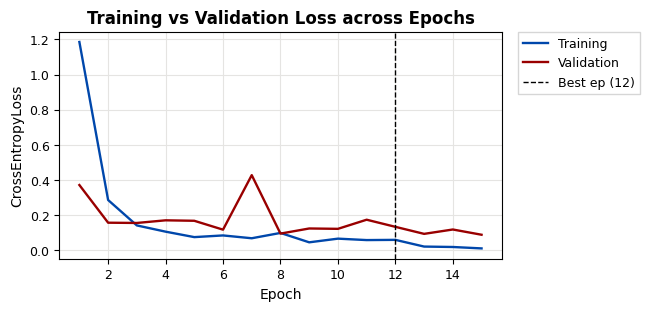

In [ ]:
# training vs validation loss
utils.plot_train_results(ep_list=ep_list, train_score=train_loss, test_score=val_loss,
                   ylabel='CrossEntropyLoss',
                   title='Training vs Validation Loss across Epochs',
                   best_epoch=est.best_epoch)

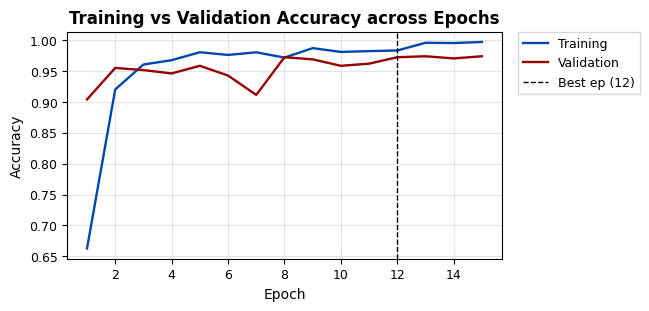

In [ ]:
# training vs validation accuracy
utils.plot_train_results(ep_list=ep_list, train_score=train_acc, test_score=val_acc,
                   ylabel='Accuracy',
                   title='Training vs Validation Accuracy across Epochs',
                   best_epoch=est.best_epoch)

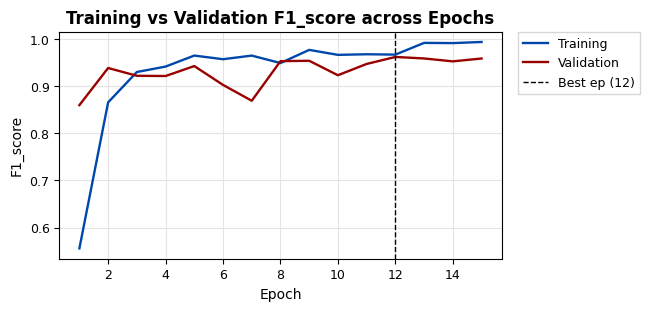

In [ ]:
# training vs validation f1_scores
utils.plot_train_results(ep_list=ep_list, train_score=train_f1, test_score=val_f1,
                   ylabel='F1_score',
                   title='Training vs Validation F1_score across Epochs',
                   best_epoch=est.best_epoch)

#### [`accuracy`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)

In [ ]:
from sklearn.metrics import accuracy_score

# calculate
acc = accuracy_score(y_true=y_true, y_pred=y_pred)
# print
print(f'Model accuracy: {acc:.4f}')

Model accuracy: 0.9698


#### [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)

In [ ]:
from sklearn.metrics import f1_score

# calculate
f1 = f1_score(y_true=y_true,
              y_pred=y_pred,
              average='macro')
# print
print(f'F1_score: {f1:.4f}')

F1_score: 0.9683


#### [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)

In [ ]:
from sklearn.metrics import classification_report

# calculate
cr = classification_report(y_true=y_true, y_pred=y_pred)
# print
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

#### [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)

In [ ]:
from sklearn.metrics import roc_auc_score
# calculate
ras = roc_auc_score(y_true=y_true,
                    y_score=y_proba,
                    multi_class='ovr')
# print
print(f'roc_auc_score: {ras:.3f}')

roc_auc_score: 1.000


#### [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay)
+ `plot_confusion_matrix` function from the `utils.py` module will help plot a `confusion_matrix`

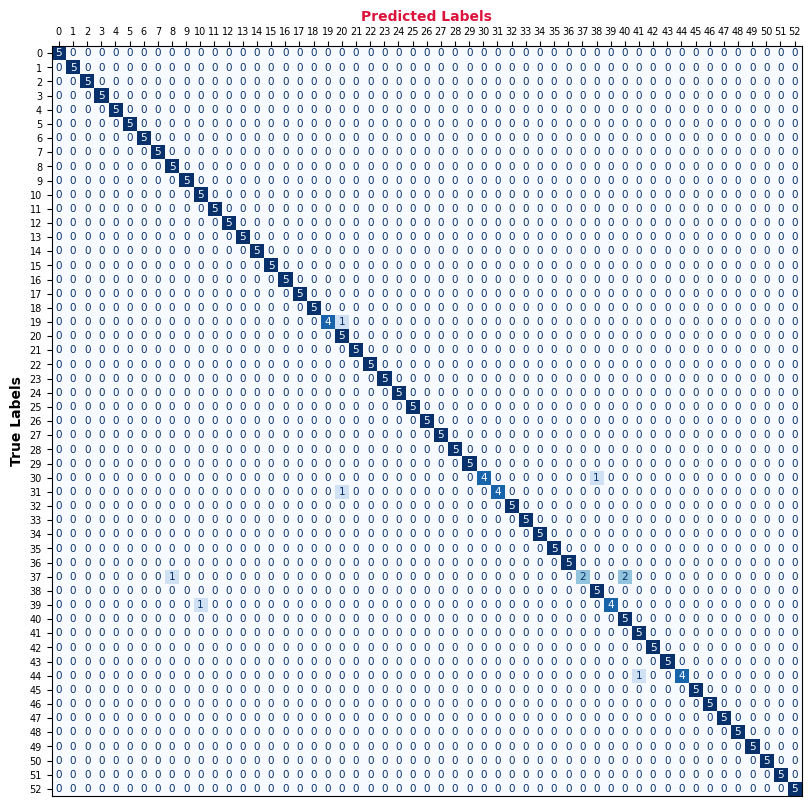

In [ ]:
utils.plot_confusion_matrix(y_true=y_true, y_pred=y_pred)

### Save model
+ Here, I'll make use of the `save_model` function from the `utils.py` module

In [ ]:
# make a parent directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# model directory
MODEL_PATH = PARENT/'cards.pth'

# view model path
print(f'Model path: {MODEL_PATH}')

Model path: models/cards.pth


In [ ]:
# save
utils.save_model(model=model, path=MODEL_PATH)

MODEL'S state_dict SAVED TO: models/cards.pth


#### Load saved model
+ Here, we'll use the `load_model` function defined in `utils.py`

In [ ]:
# first, create an object of the model class
loaded_model, _, _ = model_builder.get_model(device)

# load
utils.load_model(model=loaded_model, path=MODEL_PATH)

### Make inference
> Here, we'll make inference:
+ On a single random data sample
+ On multiple `(12)` random data samples

#### Make inference on single image
> Using `make_single_inference` in `utils.py` module

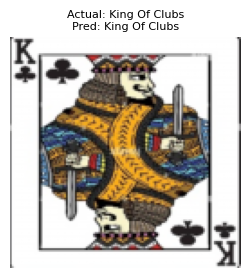

In [ ]:
# make inference on single random image from test set
utils.make_single_inference(loaded_model, test_dl.dataset, label_map, device)

#### Making inference on multiple images
> Using `make_multiple_inference` in `utils.py` module

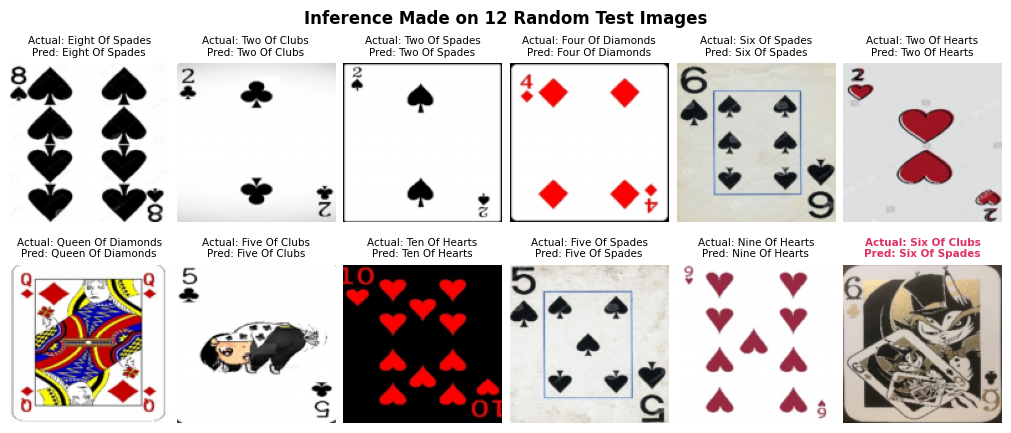

In [ ]:
# make inference on 12 random images from test set
utils.make_multiple_inference(loaded_model, test_dl.dataset, label_map, device)

#### Inference on custom images
> Here, I'll be making inference on custom images uploaded from my machine
+ To do this, we'll make use of the `custom_inference()` function from the `utils` module

Saving 2025-04-16 10_51_48-Tiny-Cards.pdf - Foxit PDF Editor.png to uploads/2025-04-16 10_51_48-Tiny-Cards.pdf - Foxit PDF Editor.png


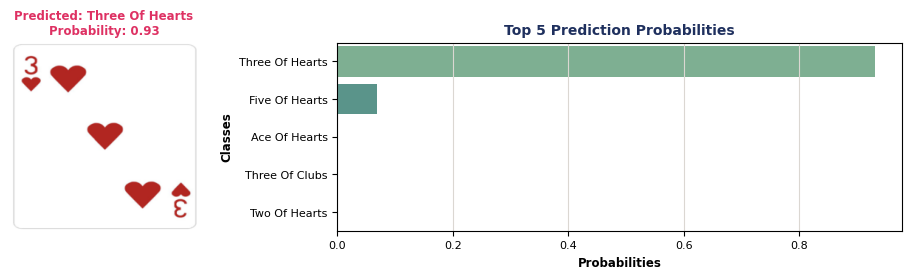

CPU times: user 417 ms, sys: 52.8 ms, total: 469 ms
Wall time: 27 s


In [ ]:
%%time
# custom inference
utils.custom_inference(model=loaded_model, device=device, label_mapper=label_map)

### Conclusion

> 📈  **Results**  
> We were able to achieve the following (on a scale of `0` -> `1`):
+ A weighted `precision`, `recall` and `f1_score` of `0.97`
+ An overall model accuracy of `0.9698`
+ An overall `roc_auc_score` of `1.00`

> 🌱 **Possible improvement**
+ In this project, I'm using a confidence score threshold as an **Out Of Distribution detector.**
+ In future, one might want to use a more robust approach

> Until next time, happy coding! 👋